In [8]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from cdft.dft3d import dft_core
from cdft.lj_eos import lj_eos

torch.set_default_dtype(torch.float64)
device = torch.device('cuda')

In [9]:
sigma = 3.73
epsilon = 148.0
parameters = {'sigma':sigma, 'epsilon':epsilon}

In [10]:
structure = Structure.from_file('structures/IRMOF-1.cif')
print('formula:        ', structure.formula)
print('num_sites:      ', structure.num_sites)
print('lattice_lengths:', structure.lattice.lengths)

formula:         Zn32 H96 C192 O104
num_sites:       424
lattice_lengths: (25.832, 25.832, 25.832)


/home/lucas/miniforge3/envs/torch/lib/python3.13/site-packages/pymatgen/io/cif.py:1290: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [11]:
T = 92.0
system_size = np.array([l for l in structure.lattice.lengths])
points = np.array([64, 64, 64])
dft = dft_core(parameters=parameters, temperature=T, system_size=system_size, angles=None, points=points, device=device)
dft.cell_size

array([0.403625, 0.403625, 0.403625])

In [12]:
forcefield = pd.DataFrame()
forcefield['type'] = ['C','H','O','Zn']
forcefield['sigma'] = np.array([3.47299, 2.84642, 3.03315, 2.4615])
forcefield['epsilon'] = np.array([47.8562, 7.64893, 48.1581, 62.3992])

def lj_potential(r,sigma,epsilon):
    return 4.0*epsilon*((sigma/r)**12-(sigma/r)**6) 

rc = 12.9

Vext = torch.zeros_like(dft.X)
U = torch.zeros_like(dft.X)
for k, site in enumerate(structure):
    sigmas = float(forcefield['sigma'][forcefield['type']==site.species_string].values[0])
    epsilons = float(forcefield['epsilon'][forcefield['type']==site.species_string].values[0])
    sigmasf = 0.5*(sigma+sigmas) 
    epsilonsf = np.sqrt(epsilon*epsilons)
    rx = dft.X-structure.cart_coords[k,0] 
    ry = dft.Y-structure.cart_coords[k,1] 
    rz = dft.Z-structure.cart_coords[k,2] 
    rx -= system_size[0]*(rx/system_size[0]).round()
    ry -= system_size[1]*(ry/system_size[1]).round()
    rz -= system_size[2]*(rz/system_size[2]).round()
    r = torch.sqrt(rx**2+ry**2+rz**2)
    U = lj_potential(r,sigmasf,epsilonsf)
    U[r==0] = np.inf
    U[r>rc] = 0.0
    Vext += U

Text(0, 0.5, '$y$ (\\AA{})')

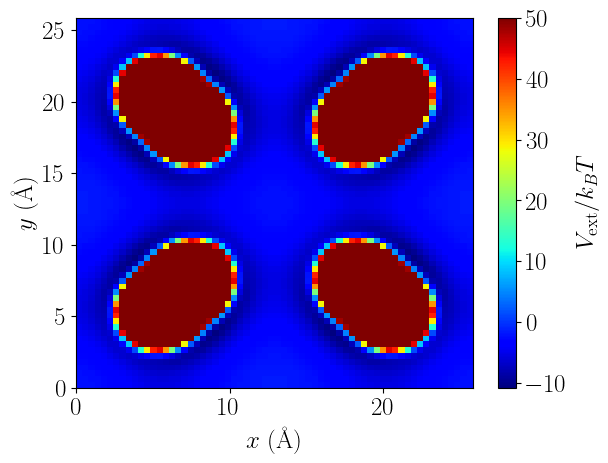

In [13]:
plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
# 'axes.linewidth':1.1, 
'lines.linewidth':1.6,
'legend.fontsize': 18,
'legend.frameon':False
#'figure.figsize':(7.9, 6.1)
})


plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),Vext[:,:,points[2]//2].cpu()/T,vmax=50.0,cmap='jet')
plt.colorbar(label=r'$V_{\mathrm{ext}}/k_B T$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')

In [19]:
P = torch.logspace(0,2,20*2)
bulk_density = torch.empty_like(P)

eos = lj_eos(parameters, T)
bulk_density[0] = eos.density(P[0],'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],bulk_density[i-1])

In [22]:
dft.initial_condition(bulk_density[0],Vext,model='ideal')

Nads = torch.zeros(len(P))
for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='fire',
                                    alpha0=0.2, dt=0.02, tol=1e-6,max_it=1001,logoutput=False)
    Nads[i] = dft.total_molecules
    print(dft.it,dft.error.numpy(),P[i].numpy(),Nads[i].numpy())
    if torch.isnan(dft.error) or dft.it > 1000: break
    else:
        torch.save(dft.rho.cpu(), f'rho.pt')
        torch.save((P,Nads), f'adsorption.pt')

92 1.441606937510807e-07 1.0 0.8270889968374203
94 9.604520833272237e-07 1.125335582600765 0.9364783096635297
92 6.642031727779731e-07 1.2663801734674032 1.0612565090569923
91 8.069716857444893e-07 1.425102670302998 1.2038638052108768
92 7.168654581762914e-07 1.6037187437513303 1.367235321907282
118 4.982511519537345e-07 1.8047217668271702 1.5549020708689845
118 7.211970246710688e-07 2.0309176209047357 1.7711932393910033
118 3.1928978233937434e-07 2.2854638641349903 2.021445477443767
119 7.659556095656065e-07 2.571913809059345 2.3123763602640945
118 7.84389161174392e-07 2.8942661247167507 2.652590628446085
119 4.969147113660468e-07 3.257020655659783 3.053348285892932
118 6.201763129004685e-07 3.665241237079628 3.529834845728002
143 9.363737107081715e-07 4.1246263829013525 4.103270135314998
139 9.276761355344179e-07 4.641588833612778 4.804697959341764
140 9.861932608758084e-07 5.223345074266842 5.682391201834377
146 9.004847278617343e-07 5.878016072274912 6.817739712632534
140 9.8221401

In [28]:
dft.rho = torch.load(f'rho.pt').to(device)
P, Nads = torch.load(f'adsorption.pt')
last = i

In [29]:
for i in range(last,len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='newton',
                                    alpha0=0.2,dt=0.002,tol=1e-6,max_it=2001,logoutput=True)
    Nads[i] = dft.total_molecules
    print(dft.it,dft.error.numpy(),P[i].numpy()*1e-5,Nads[i].numpy())
    if torch.isnan(dft.error) or dft.it > 2000: break
    else:
        torch.save(dft.rho.cpu(), f'rho.pt')
        torch.save((P,Nads), f'adsorption.pt')

Newton iter 0, Residual: 8.6065e-02
Newton iter 1, Residual: 4.4293e-01
Newton iter 2, Residual: 1.2114e+00
Newton iter 3, Residual: 9.2732e+29
4 nan 0.0002728333376486768 nan


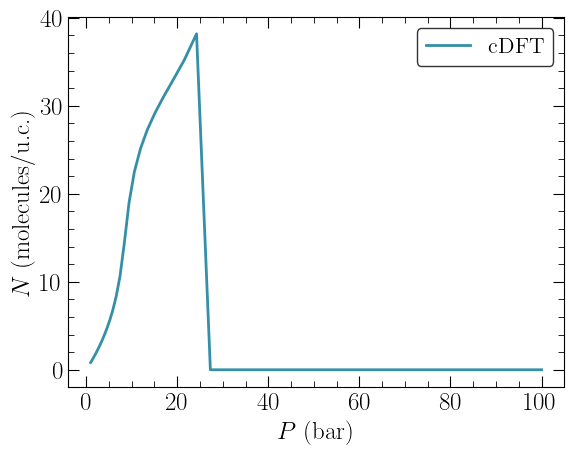

In [25]:
import seaborn as sns

colors = sns.color_palette("mako")

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif',  
#'figure.figsize':(7.9, 6.1)
})

plt.plot(P, Nads, '-', color=colors[3], linewidth=2.0, label='cDFT')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$N$ (molecules/u.c.)', fontsize=18)
# plt.xlim([0.0,100.])
# plt.ylim([None,0.004])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=8, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')
# plt.savefig('figures/isotherm_methane.pdf', bbox_inches='tight')

Text(0, 0.5, '$y$ (\\AA{})')

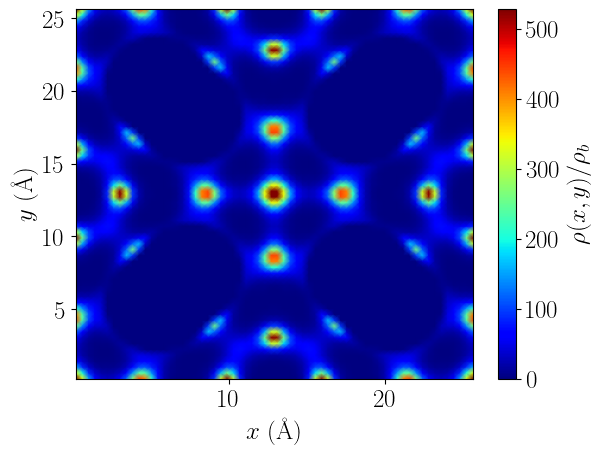

In [105]:
plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),dft.rho[:,:,points[2]//2].cpu()/dft.rhob.cpu(),cmap='jet',shading='gouraud')
plt.colorbar(c, label=r'$\rho(x,y)/ \rho_b$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')